In [4]:
# Generate a dataset from Gaussian Mixture Model

In [5]:
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import SGDClassifier
import time 

In [6]:
def genClusterCenters(numDims): 
    clusterCenters = []
    clusterCenters.append(np.random.rand(numDims))
    newCenter = np.random.rand(numDims)
    newCenter = newCenter / np.linalg.norm(newCenter)
    while np.linalg.norm(newCenter - clusterCenters[0]) >= 1:
        newCenter = np.random.rand(numDims)
        newCenter = newCenter / np.linalg.norm(newCenter)
    clusterCenters.append(newCenter)
    newCenter = np.random.rand(numDims)
    while np.linalg.norm(newCenter - clusterCenters[0]) >= 1 and np.linalg.norm(newCenter - clusterCenters[1]) >= 1:
        newCenter = np.random.rand(numDims)
        newCenter = newCenter / np.linalg.norm(newCenter)
    clusterCenters.append(newCenter)
    return np.array(clusterCenters)

In [7]:
# Method for generating a dataset from a gaussian mixture model
def genMixtureModelDataset(numPoints, numDims, numClusters):
    # Randomly initialize gaussians (define by mean)
    # clusterCenters = np.random.rand(numClusters, numDims)
    clusterCenters = genClusterCenters(numDims)
    clusterTargets = np.array([[-1 if random.random() < 0.5 else 1] for i in range(0, numClusters)])
    # Ensure at least one of each class in cluster targets 
    if(not np.isin(-1, clusterTargets)):
        clusterTargets[np.random.randint(0,numClusters)] = -1
    if(not np.isin(1, clusterTargets)):
        clusterTargets[np.random.randint(0,numClusters)] = 1
    # Generate data-points 
    # randomly and uniformly sample points from the gaussians defined by the cluster centers
    data = []
    targets = []
    # Define covariance matrix 
    cov = np.identity(numDims)
    for i in range(0, numPoints):
        clusterSelection = np.random.randint(0, numClusters)
        sample = stats.multivariate_normal.rvs(mean=clusterCenters[clusterSelection],cov=cov)
        data.append(sample)
        targets.append(clusterTargets[clusterSelection])
    data = np.array(data)
    targets = np.array(targets)
    return data, targets.ravel(), clusterCenters

Text(0, 0.5, 'Feature 2')

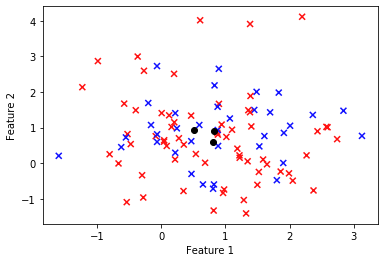

In [8]:
# Visualize 2D sampling of the mixture model
X, y, centers = genMixtureModelDataset(100, 2, 3)
cmap_bold = ListedColormap(['#FF1111', '#1111FF'])
plt.figure()
plt.scatter(X[:,0],X[:,1],c=np.clip(y,0,1).ravel(), cmap=cmap_bold, marker='x')
plt.plot(centers[:,0], centers[:,1], 'o', color='black')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")


In [9]:
# Validation curve graphing
def generateGraph(variable, trainScoresMean, testScoresMean,\
    trainScoresStd, testScoresStd,\
    xLabel, yLabel, title, log=False):
    plt.figure()
    if log is False:
        plt.plot(variable, trainScoresMean, "-o", color="blue",\
            label="Training Accuracy")
        plt.plot(variable, testScoresMean, "-o", color="red",\
            label="Cross-Validation Accuracy")
    else: 
        plt.semilogx(variable, trainScoresMean, "-o",\
            color="blue", label="Training Accuracy")
        plt.semilogx(variable, testScoresMean, "-o",\
            color="red", label="Cross-Validation Accuracy")
    plt.fill_between(variable, trainScoresMean-trainScoresStd,\
        trainScoresMean+trainScoresStd, alpha=0.1, color="blue")
    plt.fill_between(variable, testScoresMean-testScoresStd,\
        testScoresMean+testScoresStd, alpha=0.1, color="red")
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.ylim((0.0,1.0))
    plt.title(title)
    plt.legend(loc="lower right")

In [10]:
# K-NN, Evaluate effect of K on classification accuracy
def evaluateKNN(D, clusterNum, X, y, centers):
    # Evaluate effect of k on classification accuracy 
    NNBasic = neighbors.KNeighborsClassifier()
    # Ks to evaluate
    Ks = np.arange(1,100,5,dtype=int)
    # Random permutation cross-validator
    cv = ShuffleSplit(n_splits=10, test_size=0.20)
    # Generate validation curve
    trainScores, testScores = validation_curve(NNBasic, X, y, 'n_neighbors', Ks,\
        cv=cv, scoring="accuracy")
    # Calculate mean and std 
    trainScoresMean = np.mean(trainScores, axis=1)
    testScoresMean = np.mean(testScores, axis=1)
    trainScoresStd = np.std(trainScores, axis=1)
    testScoresStd = np.std(testScores, axis=1)
    # Graph
    generateGraph(Ks, trainScoresMean, testScoresMean,\
        trainScoresStd, testScoresStd, "K", "Classification Accuracy",\
        "Validation Curve for K\n(KNN on Mixture Model, " + str(D) + "D, " + str(clusterNum) + " clusters)", log=False)
    '''
    # Time fitting 
    start = time.time() 
    NNBasic.fit(X,y)
    elapsed = time.time() - start 
    print("Fitting time for D = " + str(D) + ": " + str(elapsed))
    start = time.time()
    NNBasic.predict([X[0]])
    elapsed = time.time() - start 
    print("Prediction time for D = " + str(D) + ": " + str(elapsed))
    '''

In [11]:
# Linear Classifier on various dimensions of X 
def evaluateLinearClass(D, clusterNum, X, y, centers):
    # A Basic Linear Classifier 
    estimator = SGDClassifier(loss="squared_loss", penalty="none",\
        max_iter=10000, shuffle=True, tol=None, learning_rate="constant",\
        eta0=0.01)
    # Random permutation cross-validator
    cv = ShuffleSplit(n_splits=10, test_size=0.20)
    # Learning curve 
    trainSizes, trainScores, testScores = learning_curve(\
        estimator, X, y, train_sizes=np.linspace(0.1,1.0,5),\
        cv=cv, scoring="accuracy")

    trainScoresMean = np.mean(trainScores, axis=1)
    testScoresMean = np.mean(testScores, axis=1)
    trainScoresStd = np.std(trainScores, axis=1)
    testScoresStd = np.std(testScores, axis=1)

    generateGraph(trainSizes, trainScoresMean, testScoresMean,\
        trainScoresStd, testScoresStd,\
        "Training Examples", "Classification Accuracy",\
        "Learning Curve (Linear Classifier, " + str(D) + "D, " + str(clusterNum) + " clusters)")
    '''
    # Time fitting 
    start = time.time() 
    estimator.fit(X,y)
    elapsed = time.time() - start 
    print("Fitting time for D = " + str(D) + ": " + str(elapsed))
    start = time.time()
    estimator.predict([X[0]])
    elapsed = time.time() - start 
    print("Prediction time for D = " + str(D) + ": " + str(elapsed))
    '''

In [ ]:
'''
clusters = [10,30]
Ds = [2, 10, 100, 1000]
for cluster in clusters:
    for D in Ds:
        evaluateLinearClass(D, cluster)
'''
Ds = [2, 10, 100, 1000]
for D in Ds: 
    X, y, centers = genMixtureModelDataset(150, D, 3)
    evaluateKNN(D, 3, X, y, centers)
    evaluateLinearClass(D, 3, X, y, centers)

In [ ]:
X, y, centers = genMixtureModelDataset(150, 2, 3)
plt.figure()
plt.plot(X[:,0], X[:,1], 'x', color=)